# AIDR Final Project - Pilot project

In [ ]:
#CELULA TEST

The scope of this notebook is to offer an example of the end to end implementation of the final project. Some tips:
* use shift+enter to run each cell
* use ctrl+alt+o to optimize your imports
* use ctrl+alt+l to arrange your code
* ctrl+click on the name of a variable/library will take you to it
* the easiest way to install a library is by going to Interpreter Settings -> Install (ctrl+alt+s to access Settings)
* use ctrl+k to commit and select the file(s) you want to commit
* use the number (#123456) of the corresponding GitHub issue in your commit message to link your commit to the issue
* use ctrl+shift+k to push your commits

### Project setup

In [1]:
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from pymongo import MongoClient
from unidecode import unidecode

sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(20, 20))

### Data gathering

In [2]:
# Data gathering from files published on different platforms
url = "https://raw.githubusercontent.com/stefanacioban/covid_19_spatial_analysis/main/data/lhdi_interpolated.csv"
lhdi = pd.read_csv(url)

In [3]:
lhdi.head()

,siruta,lhdi_2018_pred
0,153400.0,41.0
1,152314.0,40.0
2,151978.0,57.8
3,151709.0,39.9
4,155118.0,50.0


This dataset contains the Local Human Development Index for each Administrative Territorial Unit (ATU) in Romania ([Sandu, 2020](https://www.sciencedirect.com/science/article/pii/S221167532100066X?via%3Dihub#b25)). The index was predicted for all ATUs with a population of less than 1000 inhabitants using spatial interpolation methods. The SIRUTA code is a unique identifier for each ATU.

In [11]:
# Check the data types of each column
lhdi.dtypes

siruta            float64
lhdi_2018_pred    float64
dtype: object

In [ ]:
# Store the csv locally to further import it to the Database
lhdi.to_csv("data/lhdi.csv", index=False)

Once this dataset was locally stored, create a new MongoDB collection and import it over there.
All intermediary csv files will have to be committed to GitHub with your code.

### Database connection

In [12]:
# uri (uniform resource identifier) defines the connection parameters
uri = 'mongodb+srv://stefanabelbe:<>@idar2022.wnugvpy.mongodb.net/test'

In [13]:
client = MongoClient(uri)
client.list_database_names()  # list the database names

ServerSelectionTimeoutError: ac-l2smgbm-shard-00-02.wnugvpy.mongodb.net:27017: timed out,ac-l2smgbm-shard-00-01.wnugvpy.mongodb.net:27017: timed out,ac-l2smgbm-shard-00-00.wnugvpy.mongodb.net:27017: timed out, Timeout: 30s, Topology Description: <TopologyDescription id: 636f648c8caadca8703af6f0, topology_type: ReplicaSetNoPrimary, servers: [<ServerDescription ('ac-l2smgbm-shard-00-00.wnugvpy.mongodb.net', 27017) server_type: Unknown, rtt: None, error=NetworkTimeout('ac-l2smgbm-shard-00-00.wnugvpy.mongodb.net:27017: timed out')>, <ServerDescription ('ac-l2smgbm-shard-00-01.wnugvpy.mongodb.net', 27017) server_type: Unknown, rtt: None, error=NetworkTimeout('ac-l2smgbm-shard-00-01.wnugvpy.mongodb.net:27017: timed out')>, <ServerDescription ('ac-l2smgbm-shard-00-02.wnugvpy.mongodb.net', 27017) server_type: Unknown, rtt: None, error=NetworkTimeout('ac-l2smgbm-shard-00-02.wnugvpy.mongodb.net:27017: timed out')>]>

In [ ]:
db = client.local
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'local')

In [ ]:
# Check out the collections names from the local database
list(db.list_collections())

[{'name': 'lhdi_2018_pred',
  'type': 'collection',
  'options': {},
  'info': {'readOnly': False,
   'uuid': UUID('2900128c-4a30-4b51-99fa-36b9ce3b7d79')},
  'idIndex': {'v': 2, 'key': {'_id': 1}, 'name': '_id_'}},
 {'name': 'siruta',
  'type': 'collection',
  'options': {},
  'info': {'readOnly': False,
   'uuid': UUID('99c43a2f-f4de-4df2-b2a3-debf844e965e')},
  'idIndex': {'v': 2, 'key': {'_id': 1}, 'name': '_id_'}},
 {'name': 'startup_log',
  'type': 'collection',
  'options': {'capped': True, 'size': 10485760},
  'info': {'readOnly': False,
   'uuid': UUID('cc78fd48-5327-4eda-9efa-6913d2e6468e')},
  'idIndex': {'v': 2, 'key': {'_id': 1}, 'name': '_id_'}}]

In [ ]:
# Create a cursor using a filter
# The {'lhdi_2018_pred': 40} filter is equivalent to SELECT * FROM local.lhdi_2018_pred WHERE lhdi_2018_pred=40
cursor = db.lhdi_2018_pred.find({'lhdi_2018_pred': 40})
for item in cursor:
    print(item)

{'_id': ObjectId('61d20d53d9221e342731f9ce'), 'siruta': 152314, 'lhdi_2018_pred': 40}
{'_id': ObjectId('61d20d53d9221e342731fc77'), 'siruta': 69447, 'lhdi_2018_pred': 40}
{'_id': ObjectId('61d20d53d9221e342731feda'), 'siruta': 86222, 'lhdi_2018_pred': 40}
{'_id': ObjectId('61d20d53d9221e342731ffe5'), 'siruta': 25291, 'lhdi_2018_pred': 40}
{'_id': ObjectId('61d20d53d9221e3427320374'), 'siruta': 93487, 'lhdi_2018_pred': 40}
{'_id': ObjectId('61d20d53d9221e342732040c'), 'siruta': 154497, 'lhdi_2018_pred': 40}


In [ ]:
# The {} filter is equivalent to SELECT * FROM local.lhdi_2018_pred
cursor = db.lhdi_2018_pred.find({})
for item in cursor:
    print(item)

{'_id': ObjectId('61d20d53d9221e342731f9cd'), 'siruta': 153400, 'lhdi_2018_pred': 41}
{'_id': ObjectId('61d20d53d9221e342731f9ce'), 'siruta': 152314, 'lhdi_2018_pred': 40}
{'_id': ObjectId('61d20d53d9221e342731f9cf'), 'siruta': 151978, 'lhdi_2018_pred': 57.8}
{'_id': ObjectId('61d20d53d9221e342731f9d0'), 'siruta': 151709, 'lhdi_2018_pred': 39.9}
{'_id': ObjectId('61d20d53d9221e342731f9d1'), 'siruta': 155118, 'lhdi_2018_pred': 50}
{'_id': ObjectId('61d20d53d9221e342731f9d2'), 'siruta': 151736, 'lhdi_2018_pred': 42.3}
{'_id': ObjectId('61d20d53d9221e342731f9d3'), 'siruta': 125588, 'lhdi_2018_pred': 43.5}
{'_id': ObjectId('61d20d53d9221e342731f9d4'), 'siruta': 152234, 'lhdi_2018_pred': 47.3}
{'_id': ObjectId('61d20d53d9221e342731f9d5'), 'siruta': 127938, 'lhdi_2018_pred': 50.7}
{'_id': ObjectId('61d20d53d9221e342731f9d6'), 'siruta': 70879, 'lhdi_2018_pred': 45.5}
{'_id': ObjectId('61d20d53d9221e342731f9d7'), 'siruta': 103194, 'lhdi_2018_pred': 46.4}
{'_id': ObjectId('61d20d53d9221e342731f

In [ ]:
# Create a pandas DataFrame with the data in the last cursor
lhdi_list = []
cursor = db.lhdi_2018_pred.find({})
for item in cursor:
    lhdi_list.append(item)
lhdi_2018_pred = pd.DataFrame(lhdi_list)

In [ ]:
lhdi_2018_pred.head()

,_id,siruta,lhdi_2018_pred
0,61d20d53d9221e342731f9cd,153400,41.0
1,61d20d53d9221e342731f9ce,152314,40.0
2,61d20d53d9221e342731f9cf,151978,57.8
3,61d20d53d9221e342731f9d0,151709,39.9
4,61d20d53d9221e342731f9d1,155118,50.0


Gather some more data, this time from an official covid-19 API

In [ ]:
# Store the endpoint in a new variable
endpoint = 'https://covid19.geo-spatial.org/api/dashboard/getCasesByCounty'

In [ ]:
response = requests.get(endpoint)
response

<Response [200]>

In [ ]:
covid_data = response.json()
covid_data

{'data': {'total': 49591,
  'data': [{'county_code': 'B',
    'total_county': 4784,
    'total_healed': 6,
    'total_dead': 105,
    'county': 'BUCUREȘTI'},
   {'county_code': 'SV',
    'total_county': 4114,
    'total_healed': 5,
    'total_dead': 242,
    'county': 'SUCEAVA'},
   {'county_code': 'AG',
    'total_county': 2656,
    'total_healed': 0,
    'total_dead': 95,
    'county': 'ARGEȘ'},
   {'county_code': 'BV',
    'total_county': 2629,
    'total_healed': 0,
    'total_dead': 60,
    'county': 'BRAȘOV'},
   {'county_code': 'GL',
    'total_county': 1784,
    'total_healed': 0,
    'total_dead': 92,
    'county': 'GALAȚI'},
   {'county_code': 'DB',
    'total_county': 1577,
    'total_healed': 6,
    'total_dead': 18,
    'county': 'DÂMBOVIȚA'},
   {'county_code': 'PH',
    'total_county': 1559,
    'total_healed': 0,
    'total_dead': 39,
    'county': 'PRAHOVA'},
   {'county_code': 'VN',
    'total_county': 1535,
    'total_healed': 0,
    'total_dead': 46,
    'county': '

In [ ]:
# Check the keys of the dictionary
covid_data.keys()

dict_keys(['data'])

In [ ]:
covid_data['data'].keys()

dict_keys(['total', 'data'])

In [ ]:
covid_data['data']['data']

[{'county_code': 'B',
  'total_county': 4784,
  'total_healed': 6,
  'total_dead': 105,
  'county': 'BUCUREȘTI'},
 {'county_code': 'SV',
  'total_county': 4114,
  'total_healed': 5,
  'total_dead': 242,
  'county': 'SUCEAVA'},
 {'county_code': 'AG',
  'total_county': 2656,
  'total_healed': 0,
  'total_dead': 95,
  'county': 'ARGEȘ'},
 {'county_code': 'BV',
  'total_county': 2629,
  'total_healed': 0,
  'total_dead': 60,
  'county': 'BRAȘOV'},
 {'county_code': 'GL',
  'total_county': 1784,
  'total_healed': 0,
  'total_dead': 92,
  'county': 'GALAȚI'},
 {'county_code': 'DB',
  'total_county': 1577,
  'total_healed': 6,
  'total_dead': 18,
  'county': 'DÂMBOVIȚA'},
 {'county_code': 'PH',
  'total_county': 1559,
  'total_healed': 0,
  'total_dead': 39,
  'county': 'PRAHOVA'},
 {'county_code': 'VN',
  'total_county': 1535,
  'total_healed': 0,
  'total_dead': 46,
  'county': 'VRANCEA'},
 {'county_code': 'IS',
  'total_county': 1328,
  'total_healed': 1,
  'total_dead': 42,
  'county': 'IA

In [ ]:
# Create a pandas DataFrame with the covid data on each county
covid_df = pd.DataFrame(covid_data['data']['data'])
covid_df.head()

,county_code,total_county,total_healed,total_dead,county
0,B,4784,6,105,BUCUREȘTI
1,SV,4114,5,242,SUCEAVA
2,AG,2656,0,95,ARGEȘ
3,BV,2629,0,60,BRAȘOV
4,GL,1784,0,92,GALAȚI


In [ ]:
# Start preprocessing the dataset by renaming one column
covid_df.rename(columns={'county_code': 'code'}, inplace=True)
covid_df.head()

,code,total_county,total_healed,total_dead,county
0,B,4784,6,105,BUCUREȘTI
1,SV,4114,5,242,SUCEAVA
2,AG,2656,0,95,ARGEȘ
3,BV,2629,0,60,BRAȘOV
4,GL,1784,0,92,GALAȚI


In [ ]:
'BUCURESTI'.title()

'Bucuresti'

In [ ]:
# Apply a lambda function to all rows of the county column in order to transform all text using the title() function
covid_df['county'] = covid_df['county'].apply(lambda x: x.title())
covid_df.head()

,code,total_county,total_healed,total_dead,county
0,B,4784,6,105,București
1,SV,4114,5,242,Suceava
2,AG,2656,0,95,Argeș
3,BV,2629,0,60,Brașov
4,GL,1784,0,92,Galați


In [ ]:
covid_df['county'] = covid_df['county'].apply(
    lambda x: unidecode(x))  # unidecode will convert the diacritics to non-accented letters
covid_df['county'] = covid_df['county'].apply(
    lambda x: x.strip())  # strip is used to strip the string from all extra spaces
covid_df.head()

,code,total_county,total_healed,total_dead,county
0,B,4784,6,105,Bucuresti
1,SV,4114,5,242,Suceava
2,AG,2656,0,95,Arges
3,BV,2629,0,60,Brasov
4,GL,1784,0,92,Galati


In [ ]:
covid_df.to_csv('Data/covid_df.csv',
                index=False)  # once the dataset is saved, create a new collection and import it to MongoDB

In [ ]:
# Gather data on the active population of each ATU
url = "https://raw.githubusercontent.com/stefanacioban/covid_19_spatial_analysis/main/data/pop_active_2021.csv"
active_pop = pd.read_csv(url)
active_pop.head()

,county,total_pop,siruta,uat,pop_age_0,pop_age_1,pop_age_10,pop_age_11,pop_age_12,pop_age_13,...,pop_age_79,pop_age_8,pop_age_80,pop_age_81,pop_age_82,pop_age_83,pop_age_84,pop_age_85,pop_age_9,pop_age_18_62
0,Arad,174244,9262.0,ARAD,1311.0,1510.0,1577.0,1662.0,1633.0,1597.0,...,NaN,1522.0,NaN,NaN,NaN,NaN,NaN,2985,1510.0,108795.0
1,Arad,8113,9459.0,CHISINEU-CRIS,63.0,78.0,68.0,70.0,92.0,90.0,...,NaN,85.0,NaN,NaN,NaN,NaN,NaN,114,59.0,5010.0
2,Arad,8848,9495.0,CURTICI,86.0,104.0,109.0,94.0,101.0,110.0,...,NaN,92.0,NaN,NaN,NaN,NaN,NaN,108,98.0,5476.0
3,Arad,9481,9538.0,INEU,71.0,76.0,93.0,94.0,98.0,81.0,...,NaN,92.0,NaN,NaN,NaN,NaN,NaN,124,91.0,5839.0
4,Arad,11096,9574.0,LIPOVA,74.0,94.0,93.0,105.0,96.0,91.0,...,NaN,104.0,NaN,NaN,NaN,NaN,NaN,203,91.0,6942.0


This data was gathered from [The Natinoal Institue of Statistics Romania (2020)](http://statistici.insse.ro/) and it contains the active population (population between 18 and 62 years).

In [ ]:
# Preprocess the active_pop dataframe
active_pop = active_pop[['county', 'total_pop', 'siruta', 'uat', 'pop_age_18_62']]  # subset the initial dataframe
active_pop.head()

,county,total_pop,siruta,uat,pop_age_18_62
0,Arad,174244,9262.0,ARAD,108795.0
1,Arad,8113,9459.0,CHISINEU-CRIS,5010.0
2,Arad,8848,9495.0,CURTICI,5476.0
3,Arad,9481,9538.0,INEU,5839.0
4,Arad,11096,9574.0,LIPOVA,6942.0


In [ ]:
active_pop.info()  # There are some null values in the pop_age_18_62 columns
# There are 3181 ATUs in Romania, however this dataset contains an extra entry. We will get rid of that when we'll do the merge (inner join) with the lhdi dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   county         3182 non-null   object 
 1   total_pop      3182 non-null   int64  
 2   siruta         3181 non-null   float64
 3   uat            3182 non-null   object 
 4   pop_age_18_62  3170 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 124.4+ KB


In [ ]:
# Fill all null values with 0
active_pop.fillna(value=0, inplace=True)

In [ ]:
# Check if there are any remaining null values
active_pop.isna().any()

county           False
total_pop        False
siruta           False
uat              False
pop_age_18_62    False
dtype: bool

In [ ]:
active_pop = active_pop.astype(
    {'siruta': 'int64'})  # convert to string type to be able to merge this dataframe with lhdi_2018_pred
active_pop = active_pop.astype({'siruta': 'str'})

In [ ]:
active_pop.dtypes

county            object
total_pop          int64
siruta            object
uat               object
pop_age_18_62    float64
dtype: object

In [ ]:
# Merge the two dataframes on the siruta code
lhdi_active_pop = lhdi_2018_pred.merge(active_pop, on='siruta')
lhdi_active_pop.head()

,_id,siruta,lhdi_2018_pred,county,total_pop,uat,pop_age_18_62
0,61d20d53d9221e342731f9cd,153400,41.0,Teleorman,2436,NASTURELU,1418.0
1,61d20d53d9221e342731f9ce,152314,40.0,Teleorman,1818,BUJORU,1018.0
2,61d20d53d9221e342731f9cf,151978,57.8,Teleorman,14362,ZIMNICEA,8963.0
3,61d20d53d9221e342731f9d0,151709,39.9,Teleorman,1466,CIUPERCENI,733.0
4,61d20d53d9221e342731f9d1,155118,50.0,Teleorman,1401,FANTANELE,742.0


In [ ]:
lhdi_active_pop.shape  # check if all rows were merged

(3181, 7)

In [ ]:
# In order to do the merge between the covid dataset and lhdi_active_pop we will need to aggregate all ATU data into counties, by using distinct functions on each numeric column
lhdi_active_pop_county = lhdi_active_pop.groupby('county').agg(
    {'lhdi_2018_pred': 'mean', 'total_pop': 'sum', 'pop_age_18_62': 'sum'})

In [ ]:
lhdi_active_pop_county.head()

,lhdi_2018_pred,total_pop,pop_age_18_62
county,,,
Alba,52.537216,370821,230414.0
Arad,55.393345,467718,291486.0
Arges,49.758516,626489,392185.0
Bacau,39.872043,732530,465121.0
Bihor,50.479208,614001,381766.0


In [ ]:
# As the index got the county values, we will need to reset it so that we can further use this column for the merge
lhdi_active_pop_county.reset_index(level=0, inplace=True)
lhdi_active_pop_county.head()

,county,lhdi_2018_pred,total_pop,pop_age_18_62
0,Alba,52.537216,370821,230414.0
1,Arad,55.393345,467718,291486.0
2,Arges,49.758516,626489,392185.0
3,Bacau,39.872043,732530,465121.0
4,Bihor,50.479208,614001,381766.0


In [ ]:
lhdi_active_pop = lhdi.merge(active_pop, on='siruta')
lhdi_active_pop.shape

(3181, 6)

In [ ]:
# Use the same normalization procedure on the county column of lhdi_active_pop_county so that the merge will be possible
lhdi_active_pop_county['county'] = lhdi_active_pop_county['county'].apply(lambda x: x.strip())

In [ ]:
def normalize(x):
    if x == 'Municipiul Bucuresti':
        x = 'Bucuresti'
    return x

In [ ]:
lhdi_active_pop_county['county'] = lhdi_active_pop_county['county'].apply(lambda x: normalize(x))
lhdi_active_pop_county.head()

,county,lhdi_2018_pred,total_pop,pop_age_18_62
0,Alba,52.537216,370821,230414.0
1,Arad,55.393345,467718,291486.0
2,Arges,49.758516,626489,392185.0
3,Bacau,39.872043,732530,465121.0
4,Bihor,50.479208,614001,381766.0


In [ ]:
lhdi_active_pop_county_covid = lhdi_active_pop_county.merge(covid_df, on='county')
lhdi_active_pop_county_covid.shape

(42, 8)

In [ ]:
lhdi_active_pop_county_covid.head()

,county,lhdi_2018_pred,total_pop,pop_age_18_62,code,total_county,total_healed,total_dead
0,Alba,52.537216,370821,230414.0,AB,671,27,23
1,Arad,55.393345,467718,291486.0,AR,799,1,77
2,Arges,49.758516,626489,392185.0,AG,2656,0,95
3,Bacau,39.872043,732530,465121.0,BC,1112,0,58
4,Bihor,50.479208,614001,381766.0,BH,836,0,22


In [ ]:
lhdi_active_pop_county_covid.to_csv('Data/lhdi_active_pop_county_covid.csv', index=False)

In [ ]:
# Get some rates (or standardize some values)
lhdi_active_pop_county_covid['death_rate'] = lhdi_active_pop_county_covid['total_dead'] / lhdi_active_pop_county_covid[
    'total_pop']
lhdi_active_pop_county_covid['infection_rate'] = lhdi_active_pop_county_covid['total_county']/lhdi_active_pop_county_covid['total_pop']
lhdi_active_pop_county_covid['healed_rate'] = lhdi_active_pop_county_covid['total_healed']/lhdi_active_pop_county_covid['total_pop']
lhdi_active_pop_county_covid['active_pop_rate'] = lhdi_active_pop_county_covid['pop_age_18_62']/lhdi_active_pop_county_covid['total_pop']
lhdi_active_pop_county_covid.head()

,county,lhdi_2018_pred,total_pop,pop_age_18_62,code,total_county,total_healed,total_dead,death_rate,infection_rate,healed_rate,active_pop_rate
0,Alba,52.537216,370821,230414.0,AB,671,27,23,0.000062,0.001809,0.000073,0.621362
1,Arad,55.393345,467718,291486.0,AR,799,1,77,0.000165,0.001708,0.000002,0.623209
2,Arges,49.758516,626489,392185.0,AG,2656,0,95,0.000152,0.004239,0.000000,0.626005
3,Bacau,39.872043,732530,465121.0,BC,1112,0,58,0.000079,0.001518,0.000000,0.634951
4,Bihor,50.479208,614001,381766.0,BH,836,0,22,0.000036,0.001362,0.000000,0.621768


<AxesSubplot:xlabel='death_rate', ylabel='infection_rate'>

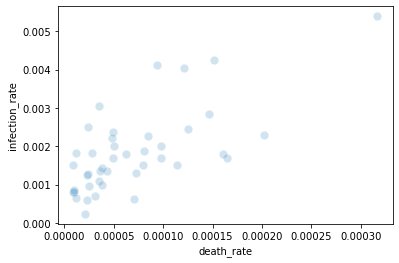

In [ ]:
# Plot some scatterplots to better understand the data
sns.scatterplot(data=lhdi_active_pop_county_covid, x="death_rate", y="infection_rate", alpha=0.2, s=70, legend=True)

<AxesSubplot:xlabel='lhdi_2018_pred', ylabel='infection_rate'>

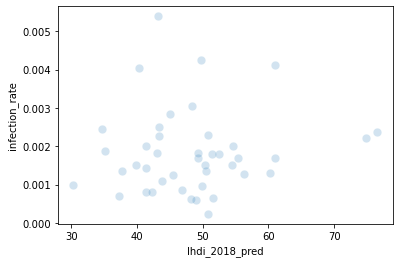

In [ ]:
sns.scatterplot(data=lhdi_active_pop_county_covid, x="lhdi_2018_pred", y="infection_rate", alpha=0.2, s=70, legend=True)

In [ ]:
# Compute some logs
lhdi_active_pop_county_covid['infection_rate_log'] = np.log(lhdi_active_pop_county_covid['infection_rate'])
lhdi_active_pop_county_covid['death_rate_log'] = np.log(lhdi_active_pop_county_covid['death_rate'])
lhdi_active_pop_county_covid['healed_rate_log'] = np.log(lhdi_active_pop_county_covid['healed_rate'])

C:\ProgramData\Anaconda3\envs\spatial_analysis\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='death_rate_log', ylabel='infection_rate_log'>

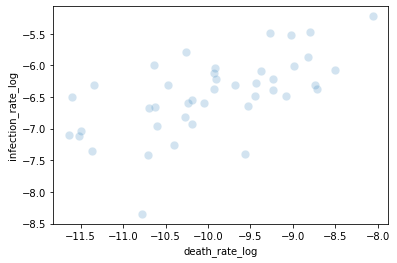

In [ ]:
sns.scatterplot(data=lhdi_active_pop_county_covid, x="death_rate_log", y="infection_rate_log", alpha=0.2, s=70,
                legend=True)

<AxesSubplot:xlabel='lhdi_2018_pred', ylabel='infection_rate_log'>

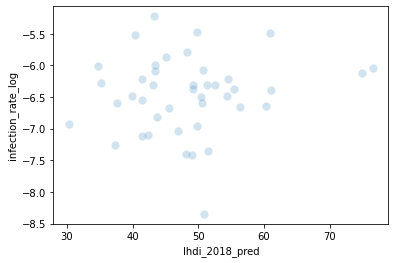

In [ ]:
sns.scatterplot(data=lhdi_active_pop_county_covid, x="lhdi_2018_pred", y="infection_rate_log", alpha=0.2, s=70,
                legend=True)

In [ ]:
lhdi_active_pop_county_covid.head()

,county,lhdi_2018_pred,total_pop,pop_age_18_62,code,total_county,total_healed,total_dead
0,Alba,52.537216,370821,230414.0,AB,671,27,23
1,Arad,55.393345,467718,291486.0,AR,799,1,77
2,Arges,49.758516,626489,392185.0,AG,2656,0,95
3,Bacau,39.872043,732530,465121.0,BC,1112,0,58
4,Bihor,50.479208,614001,381766.0,BH,836,0,22


In [8]:
# Gather geospatial data on Romania's counties
geo_json_url = "https://raw.githubusercontent.com/geospatialorg/covid19/master/api/counties.geojson"

In [9]:
county_gdf = gpd.read_file(geo_json_url)
county_gdf.head(2)

,gid,county,county_code,x_cen,y_cen,geometry
0,1,BISTRIȚA-NĂSĂUD,BN,2.729655e+06,5.981001e+06,"POLYGON ((2755480.220 5941339.590, 2754378.160..."
1,2,HUNEDOARA,HD,2.553356e+06,5.741102e+06,"POLYGON ((2580463.720 5666532.690, 2580107.500..."


In [10]:
county_gdf.shape

(43, 6)

In [11]:
county_gdf.drop(columns=['county'], inplace=True)

In [12]:
county_gdf.rename(columns={'county_code': 'code'}, inplace=True)
county_gdf.head()

,gid,code,x_cen,y_cen,geometry
0,1,BN,2.729655e+06,5.981001e+06,"POLYGON ((2755480.220 5941339.590, 2754378.160..."
1,2,HD,2.553356e+06,5.741102e+06,"POLYGON ((2580463.720 5666532.690, 2580107.500..."
2,3,BT,2.979024e+06,6.083635e+06,"POLYGON ((3014542.940 6021798.540, 3014787.850..."
3,4,AR,2.421971e+06,5.824345e+06,"POLYGON ((2504120.810 5819440.400, 2503107.810..."
4,5,BR,3.080402e+06,5.635431e+06,"POLYGON ((3043040.730 5589823.640, 3040090.770..."


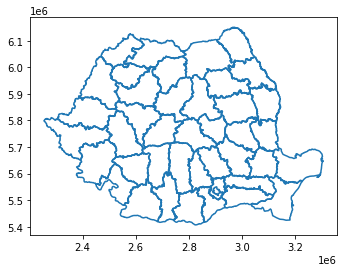

In [13]:
county_gdf.boundary.plot()

In [14]:
lhdi_active_pop_county_covid = county_gdf.merge(lhdi_active_pop_county_covid, on='code')
lhdi_active_pop_county_covid.shape

(42, 19)

In [15]:
lhdi_active_pop_county_covid.head()

,gid,code,x_cen,y_cen,geometry,county,lhdi_2018_pred,total_pop,pop_age_18_62,total_county,total_healed,total_dead,death_rate,infection_rate,healed_rate,active_pop_rate,infection_rate_log,death_rate_log,healed_rate_log
0,1,BN,2.729655e+06,5.981001e+06,"POLYGON ((2755480.220 5941339.590, 2754378.160...",Bistrita-Nasaud,50.777222,326580,203812.0,754,0,66,0.000202,0.002309,0.000000,0.624080,-6.071038,-8.506775,-inf
1,2,HD,2.553356e+06,5.741102e+06,"POLYGON ((2580463.720 5666532.690, 2580107.500...",Hunedoara,51.358319,447761,282382.0,811,3,72,0.000161,0.001811,0.000007,0.630653,-6.313747,-8.735349,-11.913403
2,3,BT,2.979024e+06,6.083635e+06,"POLYGON ((3014542.940 6021798.540, 3014787.850...",Botosani,34.692308,454026,286228.0,1109,3,57,0.000126,0.002443,0.000007,0.630422,-6.014696,-8.982858,-11.927297
3,4,AR,2.421971e+06,5.824345e+06,"POLYGON ((2504120.810 5819440.400, 2503107.810...",Arad,55.393345,467718,291486.0,799,1,77,0.000165,0.001708,0.000002,0.623209,-6.372260,-8.711815,-13.055621
4,5,BR,3.080402e+06,5.635431e+06,"POLYGON ((3043040.730 5589823.640, 3040090.770...",Braila,43.111364,336027,209509.0,615,0,4,0.000012,0.001830,0.000000,0.623489,-6.303325,-11.338652,-inf


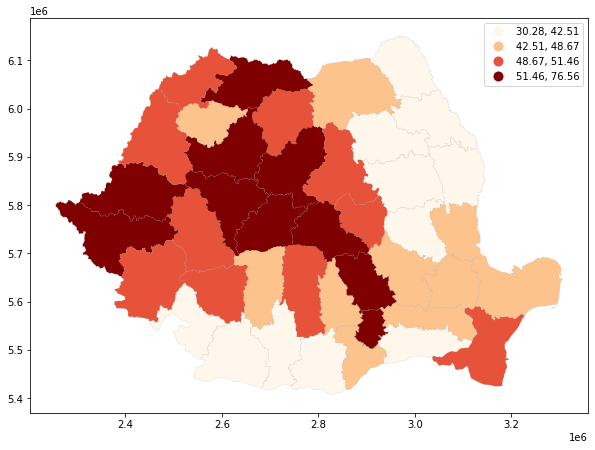

In [16]:
plt = lhdi_active_pop_county_covid.plot(column=lhdi_active_pop_county_covid['lhdi_2018_pred'], scheme='Quantiles', k=4,
                                        cmap='OrRd', figsize=(10, 10), edgecolor='gray', linewidth=0.1, legend=True)

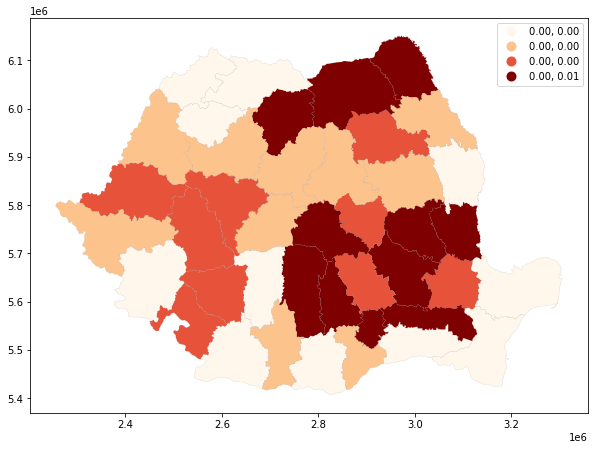

In [17]:
plt = lhdi_active_pop_county_covid.plot(column=lhdi_active_pop_county_covid['infection_rate'], scheme='Quantiles', k=4,
                                        cmap='OrRd', figsize=(10, 10), edgecolor='gray', linewidth=0.1, legend=True)

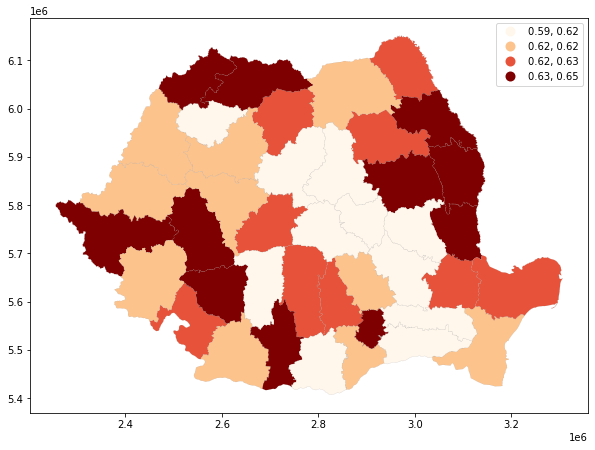

In [18]:
plt = lhdi_active_pop_county_covid.plot(column=lhdi_active_pop_county_covid['active_pop_rate'], scheme='Quantiles', k=4,
                                        cmap='OrRd', figsize=(10, 10), edgecolor='gray', linewidth=0.1, legend=True)

/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


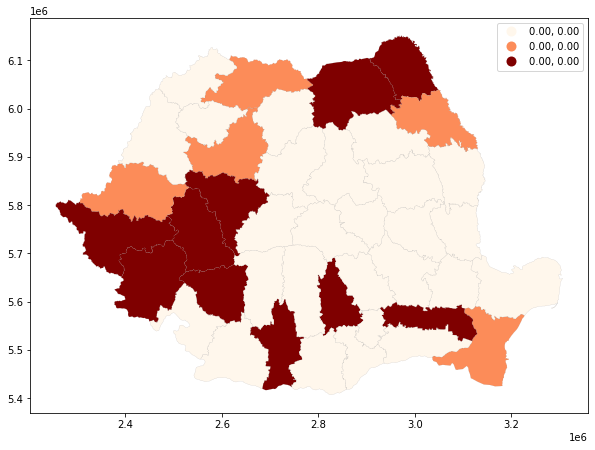

In [19]:
plt = lhdi_active_pop_county_covid.plot(column=lhdi_active_pop_county_covid['healed_rate'], scheme='Quantiles', k=4,
                                        cmap='OrRd', figsize=(10, 10), edgecolor='gray', linewidth=0.1, legend=True)